# Self-Supervised Learning на датасете Wine Quality

В этом ноутбуке исследуются методы self-supervised learning на табличных данных. Сравниваются контрастивный метод SimCLR, метод без негативов SimSiam и masked autoencoding. Оценка производится через linear probe и k-NN.


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


## 1. Подготовка данных

Загружаем датасет Wine Quality и разделяем на train/val/test выборки со стратификацией по качеству. Применяем StandardScaler на основе train статистик.


In [4]:
wine = fetch_openml('wine-quality-red', version=1, as_frame=True, parser='pandas')
X = wine.data.values
y = wine.target.astype(int).values

print(f"Dataset shape: {X.shape}")
print(f"Target distribution: {np.bincount(y)}")
print(f"Quality range: [{y.min()}, {y.max()}]")


Dataset shape: (1599, 11)
Target distribution: [  0   0   0  10  53 681 638 199  18]
Quality range: [3, 8]


In [5]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (959, 11), Val: (320, 11), Test: (320, 11)


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]
print(f"Input dimension: {input_dim}")


Input dimension: 11


## 2. Бейзлайны без обучения представлений

### 2.1 PCA + Linear Probe

PCA проецирует данные на главные компоненты:

$$z = W^\top (x - \mu)$$

где $W \in \mathbb{R}^{d \times d_z}$ содержит топ-$d_z$ собственных векторов.


In [7]:
def evaluate_regression_probe(z_train, y_train, z_val, y_val, z_test, y_test):
    model = Ridge(alpha=1.0)
    model.fit(z_train, y_train)
    
    y_test_pred = model.predict(z_test)
    
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    return {'test_rmse': test_rmse, 'test_r2': test_r2}

def evaluate_knn(z_train, y_train, z_test, y_test, k=5):
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(z_train, y_train)
    
    y_pred = knn.predict(z_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    return {'accuracy': acc, 'macro_f1': f1}


In [8]:
baseline_results = {}

for d_z in [8]:
    print(f"\n{'='*60}")
    print(f"PCA with d_z={d_z}")
    print(f"{'='*60}")
    
    pca = PCA(n_components=d_z, random_state=42)
    z_train = pca.fit_transform(X_train_scaled)
    z_val = pca.transform(X_val_scaled)
    z_test = pca.transform(X_test_scaled)
    
    probe_metrics = evaluate_regression_probe(z_train, y_train, z_val, y_val, z_test, y_test)
    print(f"Linear probe: RMSE={probe_metrics['test_rmse']:.4f}, R2={probe_metrics['test_r2']:.4f}")
    
    knn_metrics = evaluate_knn(z_train, y_train, z_test, y_test, k=5)
    print(f"k-NN (k=5): Accuracy={knn_metrics['accuracy']:.4f}, Macro-F1={knn_metrics['macro_f1']:.4f}")
    
    baseline_results[f'PCA-{d_z}'] = {
        'z_test': z_test,
        **probe_metrics,
        **knn_metrics
    }



PCA with d_z=8
Linear probe: RMSE=0.6319, R2=0.3812
k-NN (k=5): Accuracy=0.5844, Macro-F1=0.3213


### 2.2 k-NN на сырых признаках


In [9]:
print(f"\n{'='*60}")
print("Raw features + k-NN")
print(f"{'='*60}")

knn_metrics = evaluate_knn(X_train_scaled, y_train, X_test_scaled, y_test, k=5)
print(f"k-NN (k=5): Accuracy={knn_metrics['accuracy']:.4f}, Macro-F1={knn_metrics['macro_f1']:.4f}")

baseline_results['Raw'] = {
    'z_test': X_test_scaled,
    **knn_metrics
}



Raw features + k-NN
k-NN (k=5): Accuracy=0.6094, Macro-F1=0.3583


## 3. Аугментации для табличных данных

Для табличных признаков используются специальные аугментации:

1. **Gaussian noise**: $\tilde{x} = x + \mathcal{N}(0, \sigma^2 \cdot \text{std}(x)^2)$
2. **Feature dropout**: случайно $m\%$ признаков заменяются на 0
3. **Feature-wise scaling**: $\tilde{x}_j = (1 + \epsilon_j) \cdot x_j$, где $\epsilon_j \sim U[-\alpha, \alpha]$


In [10]:
class TabularAugmentation:
    def __init__(self, noise_std=0.1, dropout_prob=0.1, scale_range=0.1):
        self.noise_std = noise_std
        self.dropout_prob = dropout_prob
        self.scale_range = scale_range
    
    def add_noise(self, x):
        noise = torch.randn_like(x) * self.noise_std
        return x + noise
    
    def feature_dropout(self, x):
        mask = torch.rand_like(x) > self.dropout_prob
        return x * mask
    
    def feature_scaling(self, x):
        scale = 1 + (torch.rand_like(x) * 2 - 1) * self.scale_range
        return x * scale
    
    def __call__(self, x):
        x = self.add_noise(x)
        x = self.feature_dropout(x)
        x = self.feature_scaling(x)
        return x


## 4. Модель энкодера

Энкодер представляет собой MLP, который проецирует входные признаки в пространство представлений размерности $d_{\text{emb}}$.

Для контрастивных методов используется дополнительная проекционная голова $g: \mathbb{R}^{d_{\text{emb}}} \to \mathbb{R}^{d_{\text{proj}}}$.


In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, emb_dim)
        )
    
    def forward(self, x):
        return self.network(x)

class ProjectionHead(nn.Module):
    def __init__(self, emb_dim=64, proj_dim=128):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(emb_dim, proj_dim),
            nn.ReLU(),
            nn.Linear(proj_dim, proj_dim)
        )
    
    def forward(self, h):
        return self.network(h)


## 5. SimCLR: контрастивное обучение

SimCLR использует InfoNCE loss для максимизации согласованности между двумя аугментированными версиями одного и того же примера:

$$\mathcal{L}_{\text{InfoNCE}} = -\log \frac{\exp(\text{sim}(z_i, z_j) / \tau)}{\sum_{k=1}^{2N} \mathbb{1}_{k \neq i} \exp(\text{sim}(z_i, z_k) / \tau)}$$

где $\text{sim}(z_i, z_j) = \frac{z_i^\top z_j}{\|z_i\| \|z_j\|}$ — косинусное сходство, $\tau$ — температура.


In [12]:
class SimCLR(nn.Module):
    def __init__(self, input_dim, emb_dim=64, proj_dim=128):
        super().__init__()
        self.encoder = Encoder(input_dim, emb_dim)
        self.projection_head = ProjectionHead(emb_dim, proj_dim)
    
    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        z = F.normalize(z, dim=-1)
        return h, z

def nt_xent_loss(z1, z2, temperature=0.5):
    batch_size = z1.shape[0]
    
    z = torch.cat([z1, z2], dim=0)
    
    sim_matrix = torch.mm(z, z.t()) / temperature
    
    mask = torch.eye(2 * batch_size, device=z.device, dtype=torch.bool)
    sim_matrix = sim_matrix.masked_fill(mask, -float('inf'))
    
    positive_sim = torch.cat([
        torch.diag(sim_matrix, batch_size),
        torch.diag(sim_matrix, -batch_size)
    ])
    
    labels = torch.arange(2 * batch_size, device=z.device)
    labels[:batch_size] = torch.arange(batch_size, 2 * batch_size, device=z.device)
    labels[batch_size:] = torch.arange(batch_size, device=z.device)
    
    loss = F.cross_entropy(sim_matrix, labels)
    
    return loss


In [13]:
def train_simclr(model, train_loader, val_loader, augmentation, epochs=100, lr=1e-3, 
                 temperature=0.5, patience=20, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for x_batch in train_loader:
            x_batch = x_batch[0].to(device)
            
            x1 = augmentation(x_batch)
            x2 = augmentation(x_batch)
            
            _, z1 = model(x1)
            _, z2 = model(x2)
            
            loss = nt_xent_loss(z1, z2, temperature)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch in val_loader:
                x_batch = x_batch[0].to(device)
                
                x1 = augmentation(x_batch)
                x2 = augmentation(x_batch)
                
                _, z1 = model(x1)
                _, z2 = model(x2)
                
                loss = nt_xent_loss(z1, z2, temperature)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    model.load_state_dict(best_model_state)
    return model


In [14]:
def extract_embeddings(model, X, device='cpu', batch_size=256):
    model.eval()
    dataset = TensorDataset(torch.FloatTensor(X))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    embeddings = []
    
    with torch.no_grad():
        for x_batch in loader:
            x_batch = x_batch[0].to(device)
            if hasattr(model, 'encoder'):
                h = model.encoder(x_batch)
            else:
                h = model(x_batch)
            embeddings.append(h.cpu().numpy())
    
    return np.vstack(embeddings)


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

print(f"\n{'='*60}")
print("Training SimCLR")
print(f"{'='*60}")

train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled))
val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

augmentation = TabularAugmentation(noise_std=0.1, dropout_prob=0.1, scale_range=0.1)

model_simclr = SimCLR(input_dim, emb_dim=64, proj_dim=128)
model_simclr = train_simclr(model_simclr, train_loader, val_loader, augmentation, 
                            epochs=100, temperature=0.5, device=device)

h_train = extract_embeddings(model_simclr, X_train_scaled, device)
h_val = extract_embeddings(model_simclr, X_val_scaled, device)
h_test = extract_embeddings(model_simclr, X_test_scaled, device)

probe_metrics = evaluate_regression_probe(h_train, y_train, h_val, y_val, h_test, y_test)
print(f"\nLinear probe: RMSE={probe_metrics['test_rmse']:.4f}, R2={probe_metrics['test_r2']:.4f}")

knn_metrics = evaluate_knn(h_train, y_train, h_test, y_test, k=5)
print(f"k-NN (k=5): Accuracy={knn_metrics['accuracy']:.4f}, Macro-F1={knn_metrics['macro_f1']:.4f}")

simclr_results = {
    'z_test': h_test,
    **probe_metrics,
    **knn_metrics
}


Using device: cuda

Training SimCLR
Epoch 10/100, Train Loss: 3.8971, Val Loss: 3.8062
Epoch 20/100, Train Loss: 3.8434, Val Loss: 3.7766
Epoch 30/100, Train Loss: 3.8475, Val Loss: 3.7321
Epoch 40/100, Train Loss: 3.8336, Val Loss: 3.7002
Epoch 50/100, Train Loss: 3.8393, Val Loss: 3.6947
Epoch 60/100, Train Loss: 3.8026, Val Loss: 3.6988
Epoch 70/100, Train Loss: 3.8128, Val Loss: 3.6765
Epoch 80/100, Train Loss: 3.7916, Val Loss: 3.6790
Epoch 90/100, Train Loss: 3.7940, Val Loss: 3.7126
Epoch 100/100, Train Loss: 3.7889, Val Loss: 3.7039

Linear probe: RMSE=0.6347, R2=0.3757
k-NN (k=5): Accuracy=0.5719, Macro-F1=0.2707


## 6. SimSiam: обучение без негативов

SimSiam не использует негативные пары и применяет stop-gradient для предотвращения коллапса:

$$\mathcal{L} = \frac{1}{2} \left[ D(p_1, \text{stopgrad}(z_2)) + D(p_2, \text{stopgrad}(z_1)) \right]$$

где $D(p, z) = -\frac{p \cdot z}{\|p\| \|z\|}$ — негативное косинусное сходство.

Архитектура: $h = f(x)$, $z = g(h)$, $p = q(z)$, где $q$ — predictor.


In [16]:
class SimSiam(nn.Module):
    def __init__(self, input_dim, emb_dim=64, proj_dim=128, pred_dim=64):
        super().__init__()
        self.encoder = Encoder(input_dim, emb_dim)
        self.projection_head = ProjectionHead(emb_dim, proj_dim)
        
        self.predictor = nn.Sequential(
            nn.Linear(proj_dim, pred_dim),
            nn.ReLU(),
            nn.Linear(pred_dim, proj_dim)
        )
    
    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        p = self.predictor(z)
        return h, z, p

def simsiam_loss(p1, p2, z1, z2):
    z1 = z1.detach()
    z2 = z2.detach()
    
    p1 = F.normalize(p1, dim=-1)
    p2 = F.normalize(p2, dim=-1)
    z1 = F.normalize(z1, dim=-1)
    z2 = F.normalize(z2, dim=-1)
    
    loss = -(p1 * z2).sum(dim=-1).mean() / 2 - (p2 * z1).sum(dim=-1).mean() / 2
    
    return loss


In [17]:
def train_simsiam(model, train_loader, val_loader, augmentation, epochs=100, lr=1e-3, 
                  patience=20, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for x_batch in train_loader:
            x_batch = x_batch[0].to(device)
            
            x1 = augmentation(x_batch)
            x2 = augmentation(x_batch)
            
            _, z1, p1 = model(x1)
            _, z2, p2 = model(x2)
            
            loss = simsiam_loss(p1, p2, z1, z2)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch in val_loader:
                x_batch = x_batch[0].to(device)
                
                x1 = augmentation(x_batch)
                x2 = augmentation(x_batch)
                
                _, z1, p1 = model(x1)
                _, z2, p2 = model(x2)
                
                loss = simsiam_loss(p1, p2, z1, z2)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    model.load_state_dict(best_model_state)
    return model


In [18]:
print(f"\n{'='*60}")
print("Training SimSiam")
print(f"{'='*60}")

model_simsiam = SimSiam(input_dim, emb_dim=64, proj_dim=128, pred_dim=64)
model_simsiam = train_simsiam(model_simsiam, train_loader, val_loader, augmentation, 
                              epochs=100, device=device)

h_train = extract_embeddings(model_simsiam, X_train_scaled, device)
h_val = extract_embeddings(model_simsiam, X_val_scaled, device)
h_test = extract_embeddings(model_simsiam, X_test_scaled, device)

probe_metrics = evaluate_regression_probe(h_train, y_train, h_val, y_val, h_test, y_test)
print(f"\nLinear probe: RMSE={probe_metrics['test_rmse']:.4f}, R2={probe_metrics['test_r2']:.4f}")

knn_metrics = evaluate_knn(h_train, y_train, h_test, y_test, k=5)
print(f"k-NN (k=5): Accuracy={knn_metrics['accuracy']:.4f}, Macro-F1={knn_metrics['macro_f1']:.4f}")

simsiam_results = {
    'z_test': h_test,
    **probe_metrics,
    **knn_metrics
}



Training SimSiam
Epoch 10/100, Train Loss: -0.9973, Val Loss: -0.9977
Epoch 20/100, Train Loss: -0.9993, Val Loss: -0.9992
Epoch 30/100, Train Loss: -0.9966, Val Loss: -0.9951
Epoch 40/100, Train Loss: -0.9981, Val Loss: -0.9979
Early stopping at epoch 47

Linear probe: RMSE=0.6386, R2=0.3679
k-NN (k=5): Accuracy=0.5625, Macro-F1=0.2641


## 7. Masked Autoencoding для табличных данных

Masked Autoencoder случайно маскирует $m\%$ признаков и обучается их восстанавливать:

$$\mathcal{L}_{\text{MAE}} = \frac{1}{|M|} \sum_{j \in M} (x_j - \hat{x}_j)^2$$

где $M$ — множество замаскированных признаков.


In [19]:
class MaskedAutoencoder(nn.Module):
    def __init__(self, input_dim, emb_dim=64, mask_ratio=0.3):
        super().__init__()
        self.mask_ratio = mask_ratio
        self.input_dim = input_dim
        
        self.encoder = Encoder(input_dim, emb_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(emb_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x, mask=None):
        if mask is None and self.training:
            mask = torch.rand(x.shape, device=x.device) < self.mask_ratio
        
        if mask is not None:
            x_masked = x.clone()
            x_masked[mask] = 0
        else:
            x_masked = x
        
        h = self.encoder(x_masked)
        x_recon = self.decoder(h)
        
        return h, x_recon, mask
    
    def compute_loss(self, x, x_recon, mask):
        if mask is not None:
            loss = F.mse_loss(x_recon[mask], x[mask])
        else:
            loss = F.mse_loss(x_recon, x)
        return loss


In [20]:
def train_mae(model, train_loader, val_loader, epochs=100, lr=1e-3, patience=20, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for x_batch in train_loader:
            x_batch = x_batch[0].to(device)
            
            _, x_recon, mask = model(x_batch)
            loss = model.compute_loss(x_batch, x_recon, mask)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch in val_loader:
                x_batch = x_batch[0].to(device)
                
                _, x_recon, mask = model(x_batch)
                loss = model.compute_loss(x_batch, x_recon, mask)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    model.load_state_dict(best_model_state)
    return model


In [21]:
print(f"\n{'='*60}")
print("Training Masked Autoencoder")
print(f"{'='*60}")

model_mae = MaskedAutoencoder(input_dim, emb_dim=64, mask_ratio=0.3)
model_mae = train_mae(model_mae, train_loader, val_loader, epochs=100, device=device)

h_train = extract_embeddings(model_mae, X_train_scaled, device)
h_val = extract_embeddings(model_mae, X_val_scaled, device)
h_test = extract_embeddings(model_mae, X_test_scaled, device)

probe_metrics = evaluate_regression_probe(h_train, y_train, h_val, y_val, h_test, y_test)
print(f"\nLinear probe: RMSE={probe_metrics['test_rmse']:.4f}, R2={probe_metrics['test_r2']:.4f}")

knn_metrics = evaluate_knn(h_train, y_train, h_test, y_test, k=5)
print(f"k-NN (k=5): Accuracy={knn_metrics['accuracy']:.4f}, Macro-F1={knn_metrics['macro_f1']:.4f}")

mae_results = {
    'z_test': h_test,
    **probe_metrics,
    **knn_metrics
}



Training Masked Autoencoder
Epoch 10/100, Train Loss: 0.6012, Val Loss: 0.4870
Epoch 20/100, Train Loss: 0.6105, Val Loss: 0.4902
Epoch 30/100, Train Loss: 0.5711, Val Loss: 0.4892
Epoch 40/100, Train Loss: 0.4898, Val Loss: 0.4683
Epoch 50/100, Train Loss: 0.5373, Val Loss: 0.4695
Epoch 60/100, Train Loss: 0.4862, Val Loss: 0.4672
Early stopping at epoch 61

Linear probe: RMSE=0.6481, R2=0.3491
k-NN (k=5): Accuracy=0.5594, Macro-F1=0.2771


## 8. Сводка результатов

Сравниваем все методы по метрикам linear probe (RMSE, R²) и k-NN (Accuracy, Macro-F1).


In [22]:
all_results = []

if 'Raw' in baseline_results:
    all_results.append({
        'Method': 'Raw',
        'Accuracy': baseline_results['Raw'].get('accuracy', 0),
        'Macro-F1': baseline_results['Raw'].get('macro_f1', 0),
        'RMSE': None,
        'R2': None
    })

if 'PCA-8' in baseline_results:
    all_results.append({
        'Method': 'PCA-8',
        'Accuracy': baseline_results['PCA-8'].get('accuracy', 0),
        'Macro-F1': baseline_results['PCA-8'].get('macro_f1', 0),
        'RMSE': baseline_results['PCA-8']['test_rmse'],
        'R2': baseline_results['PCA-8']['test_r2']
    })

all_results.append({
    'Method': 'SimCLR',
    'Accuracy': simclr_results['accuracy'],
    'Macro-F1': simclr_results['macro_f1'],
    'RMSE': simclr_results['test_rmse'],
    'R2': simclr_results['test_r2']
})

all_results.append({
    'Method': 'SimSiam',
    'Accuracy': simsiam_results['accuracy'],
    'Macro-F1': simsiam_results['macro_f1'],
    'RMSE': simsiam_results['test_rmse'],
    'R2': simsiam_results['test_r2']
})

all_results.append({
    'Method': 'MAE',
    'Accuracy': mae_results['accuracy'],
    'Macro-F1': mae_results['macro_f1'],
    'RMSE': mae_results['test_rmse'],
    'R2': mae_results['test_r2']
})

results_df = pd.DataFrame(all_results)
print("\n" + "="*80)
print("SUMMARY OF ALL METHODS")
print("="*80)
print(results_df.to_string(index=False))



SUMMARY OF ALL METHODS
 Method  Accuracy  Macro-F1     RMSE       R2
    Raw  0.609375  0.358320      NaN      NaN
  PCA-8  0.584375  0.321302 0.631890 0.381216
 SimCLR  0.571875  0.270695 0.634678 0.375743
SimSiam  0.562500  0.264130 0.638636 0.367932
    MAE  0.559375  0.277130 0.648086 0.349089


## 9. Визуализация: 2D проекции

Применяем t-SNE для визуализации изученных представлений.


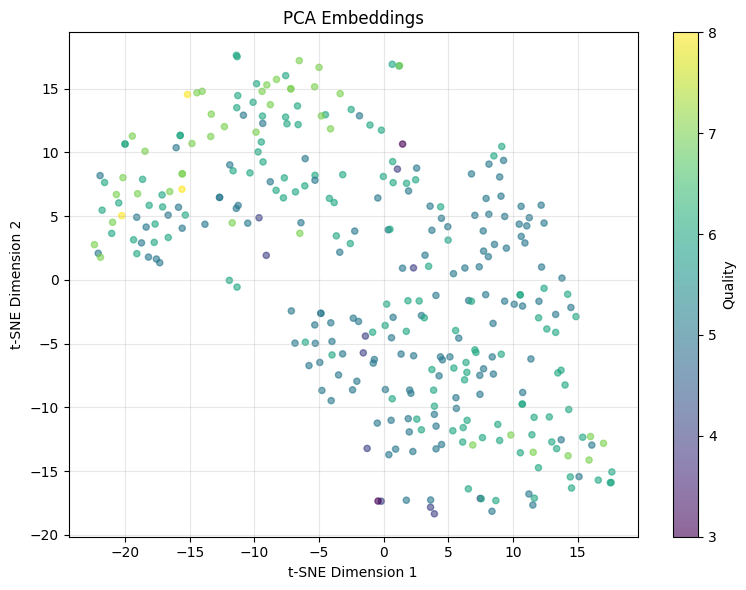

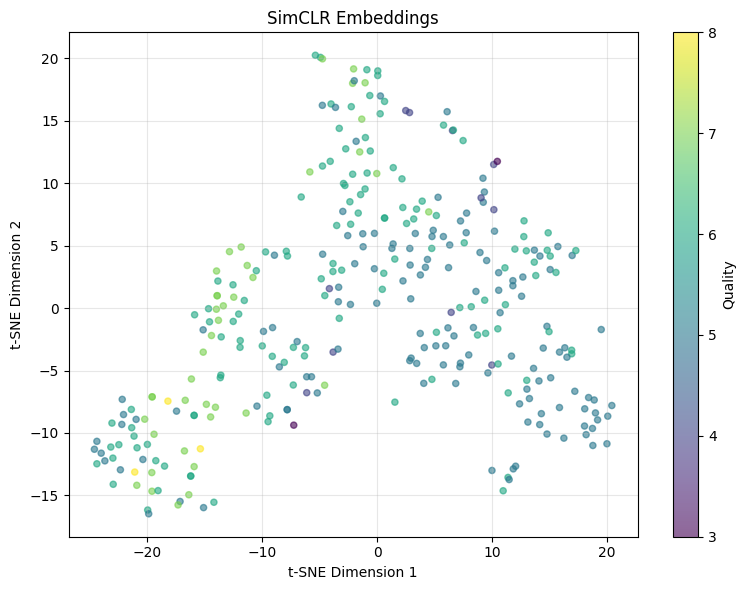

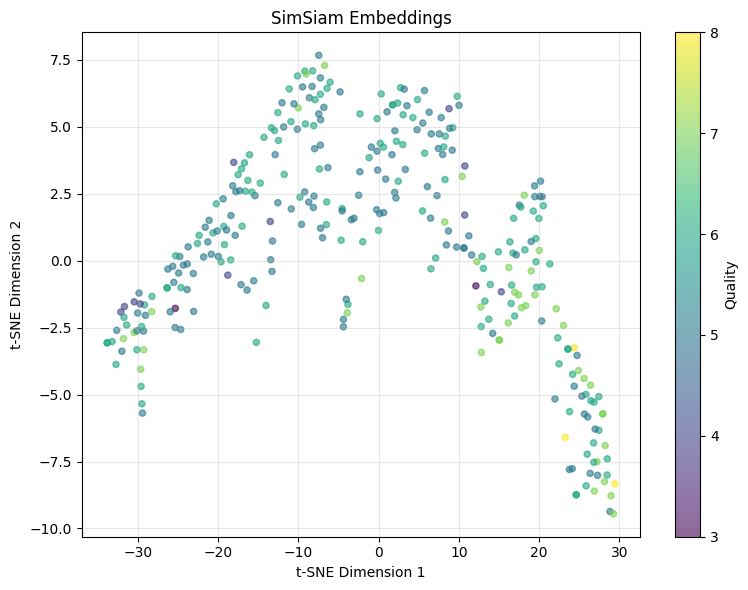

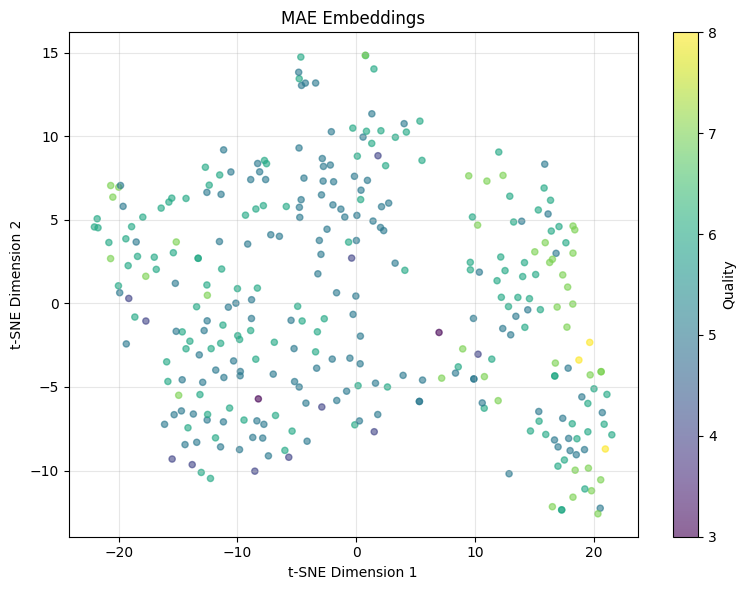

In [23]:
def plot_2d_embeddings(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    emb_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap='viridis', alpha=0.6, s=20)
    plt.colorbar(scatter, label='Quality')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_2d_embeddings(baseline_results['PCA-8']['z_test'], y_test, 'PCA Embeddings')
plot_2d_embeddings(simclr_results['z_test'], y_test, 'SimCLR Embeddings')
plot_2d_embeddings(simsiam_results['z_test'], y_test, 'SimSiam Embeddings')
plot_2d_embeddings(mae_results['z_test'], y_test, 'MAE Embeddings')
